In [1]:
import findspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## To print everything in a cell, not just the last print statement ##
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

findspark.init("/Users/ajaysankarreddychintagunta/spark-3.0.0-preview2-bin-hadoop2.7")

# I was getting the following JVM error while creating a spark session.
# Downgrading the pyspark version to 2.3.2 has resolved the issue.
# https://stackoverflow.com/questions/53161939/pyspark-error-does-not-exist-in-the-jvm-error-when-initializing-sparkcontext

In [2]:
spark = SparkSession.builder.appName('HomeCreditLoanRiskEstimation').getOrCreate()
loan_history_df = spark.read.csv('application_train.csv', header=True, inferSchema=True)

In [3]:
loan_history_df.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

In [4]:
# Sk_ID_Curr is the id column which we dont need it in the process #so we get rid of it. 
# And we rename the name of our target variable to "label"

# According to the dataset description, label -> 1 indicates that the loan is NOT paid in time,
# and the label -> 0 indicates that the loan has been repaid well within the time window.

drop_col = ['SK_ID_CURR']
loan_history_df = loan_history_df.select([
    column for column in loan_history_df.columns if column not in drop_col])
loan_history_df = loan_history_df.withColumnRenamed('TARGET', 'label')
# loan_history_df['label'] = 1 - loan_history_df['label'] # Switches the labels of the loan paid status
loan_history_df.groupby('label').count().toPandas()

,label,count
0,1,24825
1,0,282686


Training data shape:  (307511, 121)


<Figure size 864x720 with 0 Axes>

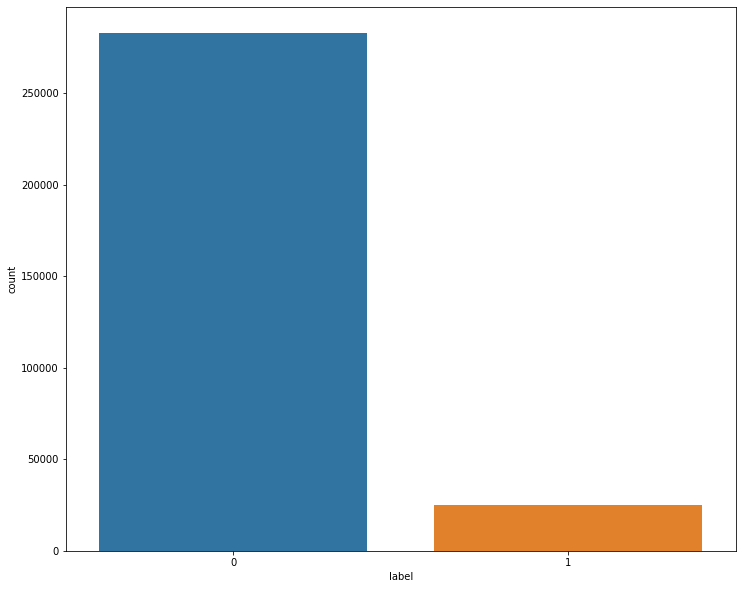

In [5]:
loan_history_df_pandas = loan_history_df.toPandas()
print('Training data shape: ', loan_history_df_pandas.shape)
plt.figure(figsize=(12,10))
sns.countplot(x='label', data=loan_history_df_pandas, order=loan_history_df_pandas['label'].value_counts().index)

<p>
    
    From this information, we see this is an imbalanced class problem. 
    There are far more loans that were repaid on time than loans that were not repaid.

</p>

<p>

    Once we get into more sophisticated machine learning models, we can weight the classes by their representation 
    in the data to reflect this imbalance.
    
</p>

In [6]:
loan_history_df_pandas.head(10)

,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,913500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,405000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
correlations = loan_history_df_pandas.corr()['label'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
label                          1.000000
Name: label, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
R

In [8]:
age_and_loan_df = pd.DataFrame(data={'loan_paid_status': loan_history_df_pandas['label'], 
                                     'age_of_applicant': loan_history_df_pandas['DAYS_BIRTH'] / -365})
age_and_loan_df
age_and_loan_df['age_of_applicant'].describe()

,loan_paid_status,age_of_applicant
0,1,25.920548
1,0,45.931507
2,0,52.180822
3,0,52.068493
4,0,54.608219
...,...,...
307506,0,25.553425
307507,0,56.917808
307508,0,41.002740
307509,1,32.769863


count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: age_of_applicant, dtype: float64

<Figure size 1440x720 with 0 Axes>

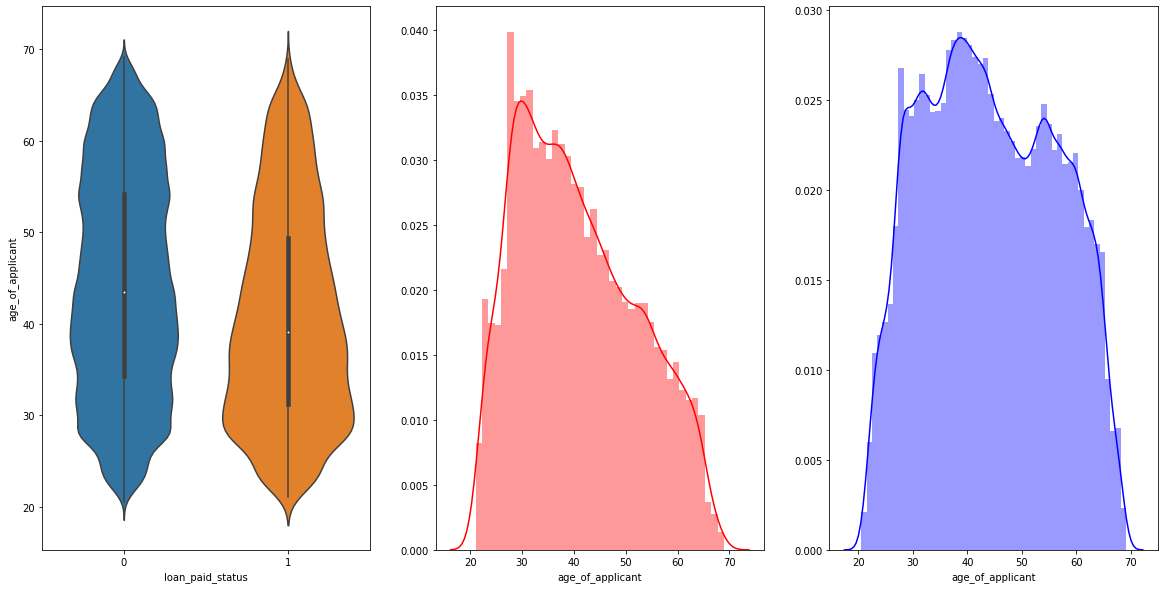

In [9]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.violinplot(x='loan_paid_status', y='age_of_applicant', data=age_and_loan_df)
plt.subplot(1,3,2)
sns.distplot(age_and_loan_df[age_and_loan_df['loan_paid_status']==1]['age_of_applicant'], label='loan_not_paid', 
             color='red')
plt.subplot(1,3,3)
sns.distplot(age_and_loan_df[age_and_loan_df['loan_paid_status']==0]['age_of_applicant'], label='loan_paid', 
             color='blue')

<p>
    If you observe above distribution we can say that most people who are not able to repay loan are younger people.
</p>

In [10]:
# Bin the age data
age_and_loan_df['YEARS_BINNED'] = pd.cut(age_and_loan_df['age_of_applicant'], bins = np.linspace(20, 70, num = 11))
age_and_loan_df.head(10)
age_groups  = age_and_loan_df.groupby('YEARS_BINNED').mean()
age_groups

,loan_paid_status,age_of_applicant,YEARS_BINNED
0,1,25.920548,"(25.0, 30.0]"
1,0,45.931507,"(45.0, 50.0]"
2,0,52.180822,"(50.0, 55.0]"
3,0,52.068493,"(50.0, 55.0]"
4,0,54.608219,"(50.0, 55.0]"
5,0,46.413699,"(45.0, 50.0]"
6,0,37.747945,"(35.0, 40.0]"
7,0,51.643836,"(50.0, 55.0]"
8,0,55.065753,"(55.0, 60.0]"
9,0,39.641096,"(35.0, 40.0]"


,loan_paid_status,age_of_applicant
YEARS_BINNED,,
"(20.0, 25.0]",0.123036,23.377522
"(25.0, 30.0]",0.111436,27.822518
"(30.0, 35.0]",0.102814,32.479037
"(35.0, 40.0]",0.089414,37.555913
"(40.0, 45.0]",0.078491,42.459346
"(45.0, 50.0]",0.074171,47.462741
"(50.0, 55.0]",0.066968,52.593136
"(55.0, 60.0]",0.055314,57.491131
"(60.0, 65.0]",0.052737,62.412459


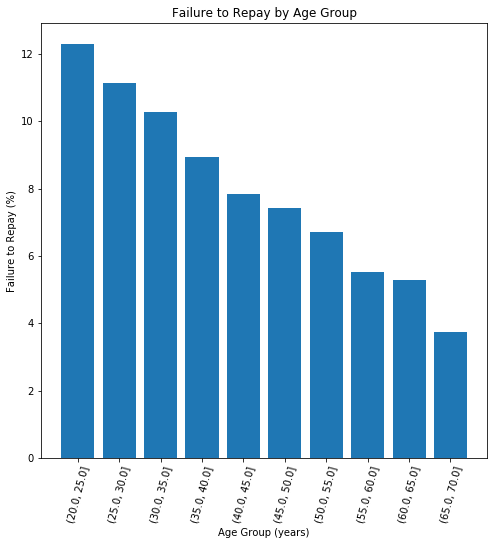

In [11]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['loan_paid_status'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

<p>
    There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

</p>

In [12]:
loan_history_df_pandas['AMT_CREDIT'].describe()
credit_amount_and_loan_df = pd.DataFrame(data={'loan paid status': loan_history_df_pandas['label'], 
                                     'credit amount': loan_history_df_pandas['AMT_CREDIT']})
credit_amount_and_loan_df

count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

,loan paid status,credit amount
0,1,406597.5
1,0,1293502.5
2,0,135000.0
3,0,312682.5
4,0,513000.0
...,...,...
307506,0,254700.0
307507,0,269550.0
307508,0,677664.0
307509,1,370107.0


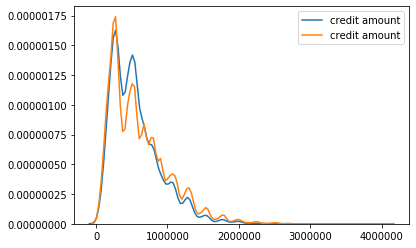

In [13]:
ax = sns.kdeplot(credit_amount_and_loan_df[credit_amount_and_loan_df['loan paid status']==1]['credit amount'])
sns.kdeplot(credit_amount_and_loan_df[credit_amount_and_loan_df['loan paid status']==0]['credit amount'], ax=ax)

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5, 0, 'Days Employment')

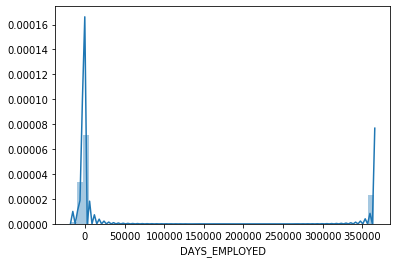

In [14]:
loan_history_df_pandas['DAYS_EMPLOYED'].describe()
plt.xlabel('Days Employment');
ax = sns.distplot(loan_history_df_pandas['DAYS_EMPLOYED'])

In [15]:
day_employed_and_loan_df = pd.DataFrame(data={'loan_paid_status': loan_history_df_pandas['label'], 
                                              'DAYS_EMPLOYED': loan_history_df_pandas[
                                                  loan_history_df_pandas['DAYS_EMPLOYED'] <= 0]['DAYS_EMPLOYED']})
day_employed_and_loan_df = day_employed_and_loan_df.dropna()
day_employed_and_loan_df
day_employed_and_loan_df['DAYS_EMPLOYED'].describe()

,loan_paid_status,DAYS_EMPLOYED
0,1,-637.0
1,0,-1188.0
2,0,-225.0
3,0,-3039.0
4,0,-3038.0
...,...,...
307504,0,-7258.0
307506,0,-236.0
307508,0,-7921.0
307509,1,-4786.0


count    252137.000000
mean      -2384.169325
std        2338.360162
min      -17912.000000
25%       -3175.000000
50%       -1648.000000
75%        -767.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

[]

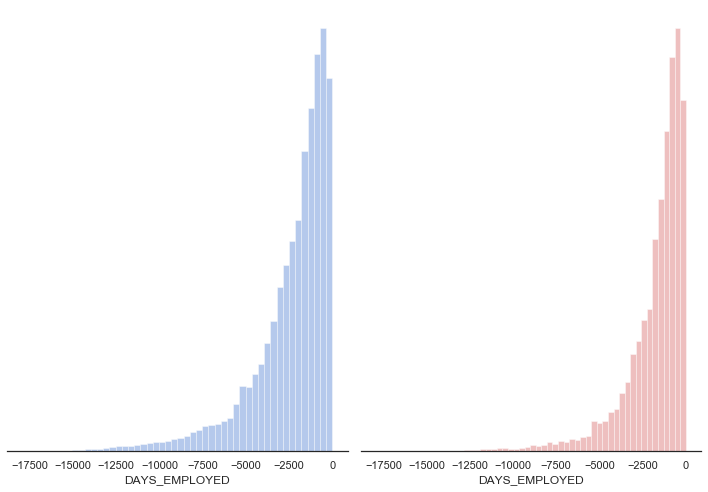

In [16]:
sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(10, 7), sharex=True)
sns.despine(left=True)

# Plot a simple histogram with binsize determined automatically
# Loan applicants who have repaid within the time window
sns.distplot(day_employed_and_loan_df[day_employed_and_loan_df['loan_paid_status'] == 0]['DAYS_EMPLOYED'], 
             kde=False, color="b", ax=axes[0])

# Plot a simple histogram with binsize determined automatically
# Loan applicants who have NOT repaid within the time window
sns.distplot(day_employed_and_loan_df[day_employed_and_loan_df['loan_paid_status'] == 1]['DAYS_EMPLOYED'], 
             kde=False, color="r", ax=axes[1])

plt.setp(axes, yticks=[])
plt.tight_layout()

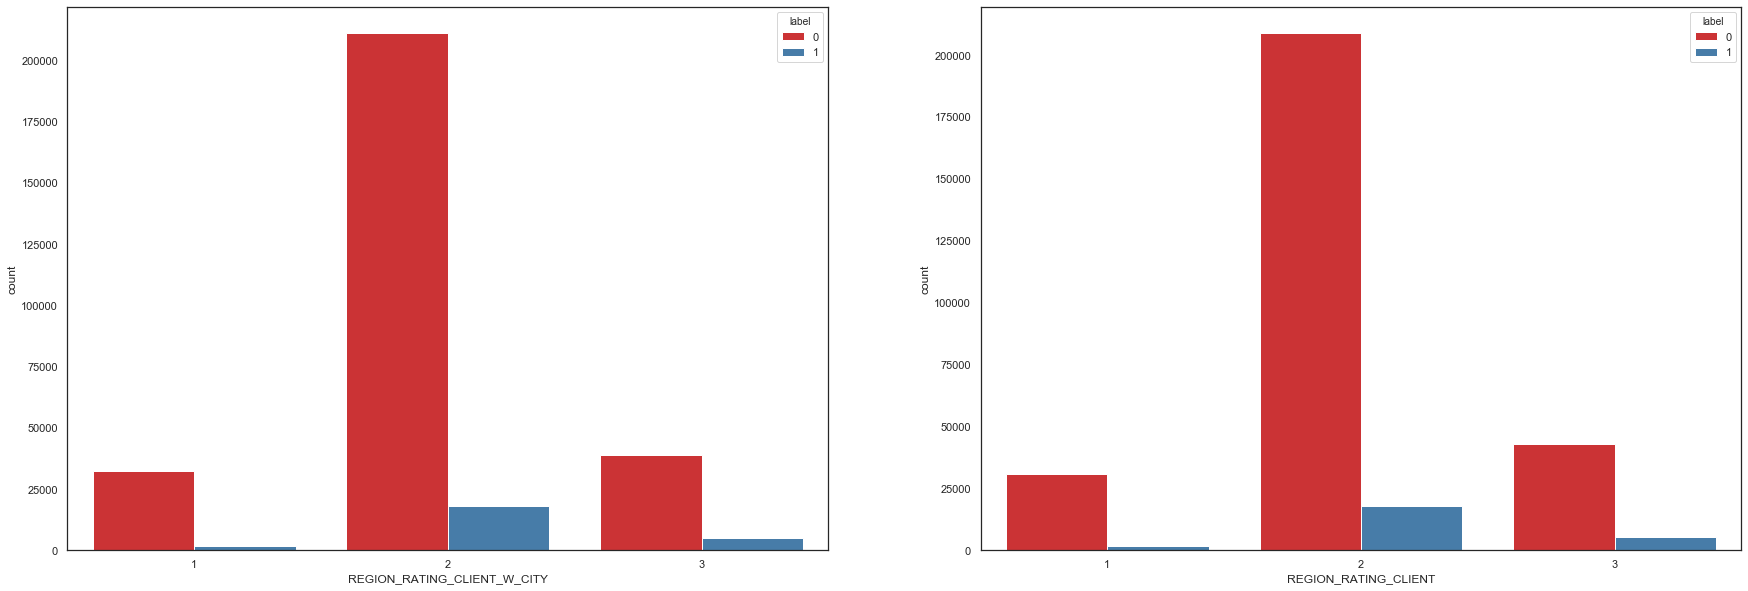

In [17]:
f, axes = plt.subplots(1, 2, figsize=(30, 10))
ax = sns.countplot(x="REGION_RATING_CLIENT_W_CITY", hue="label", data=loan_history_df_pandas, palette="Set1", ax=axes[0])
ax = sns.countplot(x="REGION_RATING_CLIENT", hue="label", data=loan_history_df_pandas, palette="Set1", ax=axes[1])

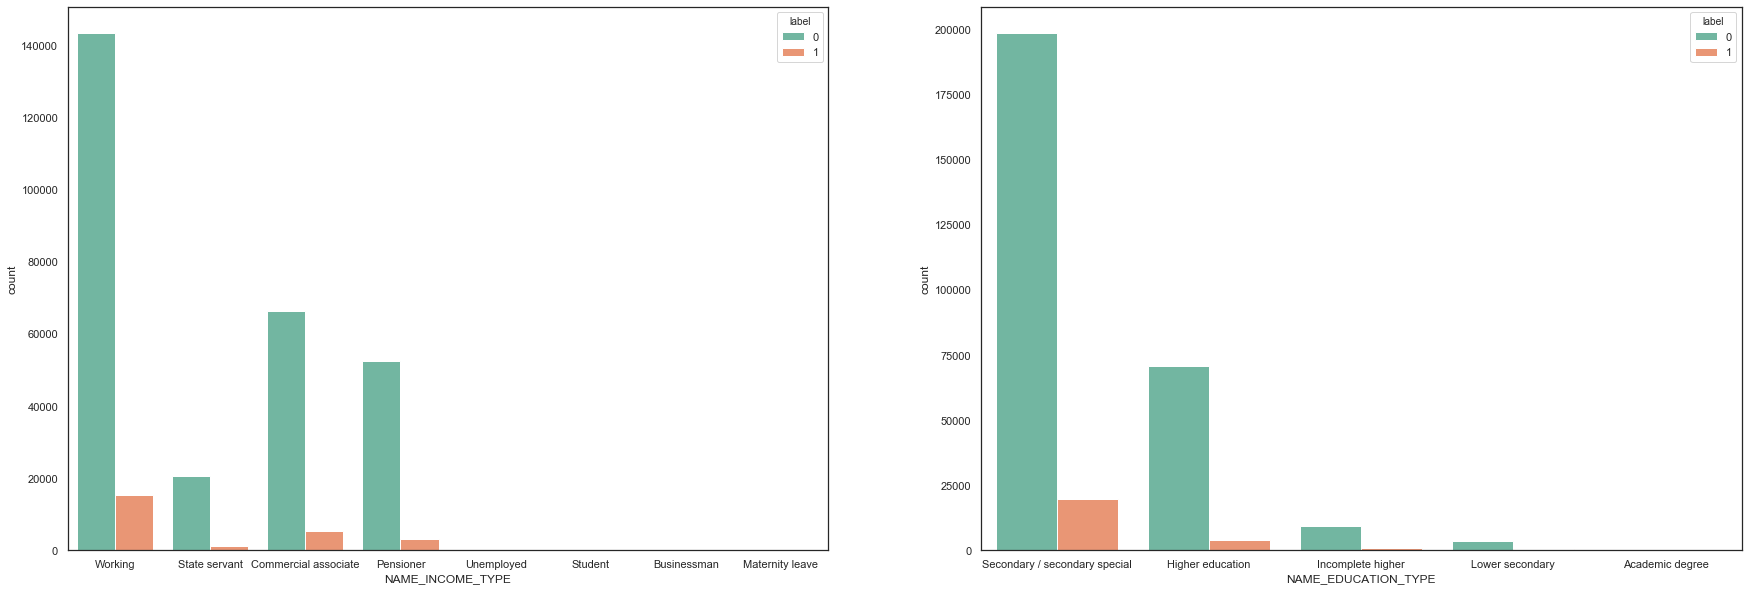

In [18]:
f, axes = plt.subplots(1, 2, figsize=(30, 10))
ax = sns.countplot(x="NAME_INCOME_TYPE", hue="label", data=loan_history_df_pandas, palette="Set2", ax=axes[0])
ax = sns.countplot(x="NAME_EDUCATION_TYPE", hue="label", data=loan_history_df_pandas, palette="Set2", ax=axes[1])

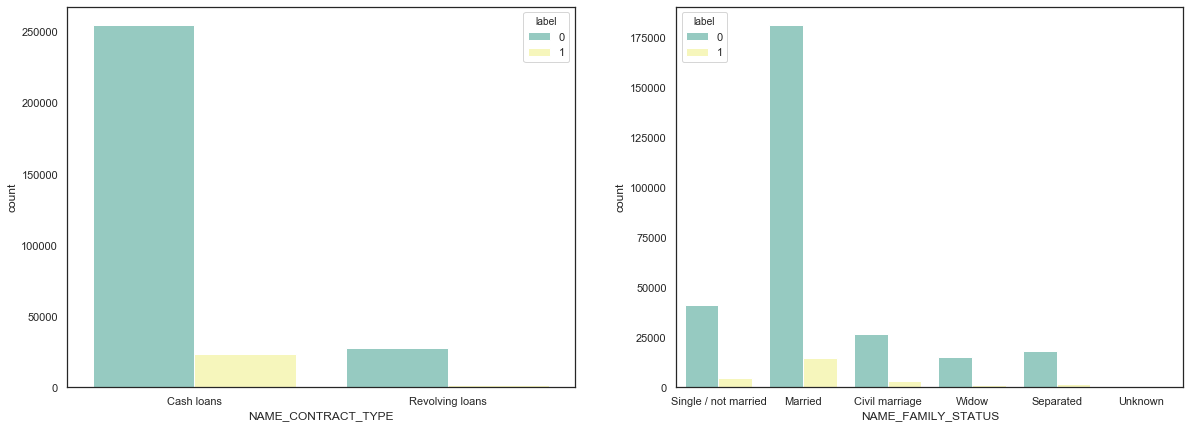

In [19]:
f, axes = plt.subplots(1, 2, figsize=(20, 7))
sns.countplot(x="NAME_CONTRACT_TYPE", hue="label", data=loan_history_df_pandas, palette="Set3", ax=axes[0])
sns.countplot(x="NAME_FAMILY_STATUS", hue="label", data=loan_history_df_pandas, palette="Set3", ax=axes[1])

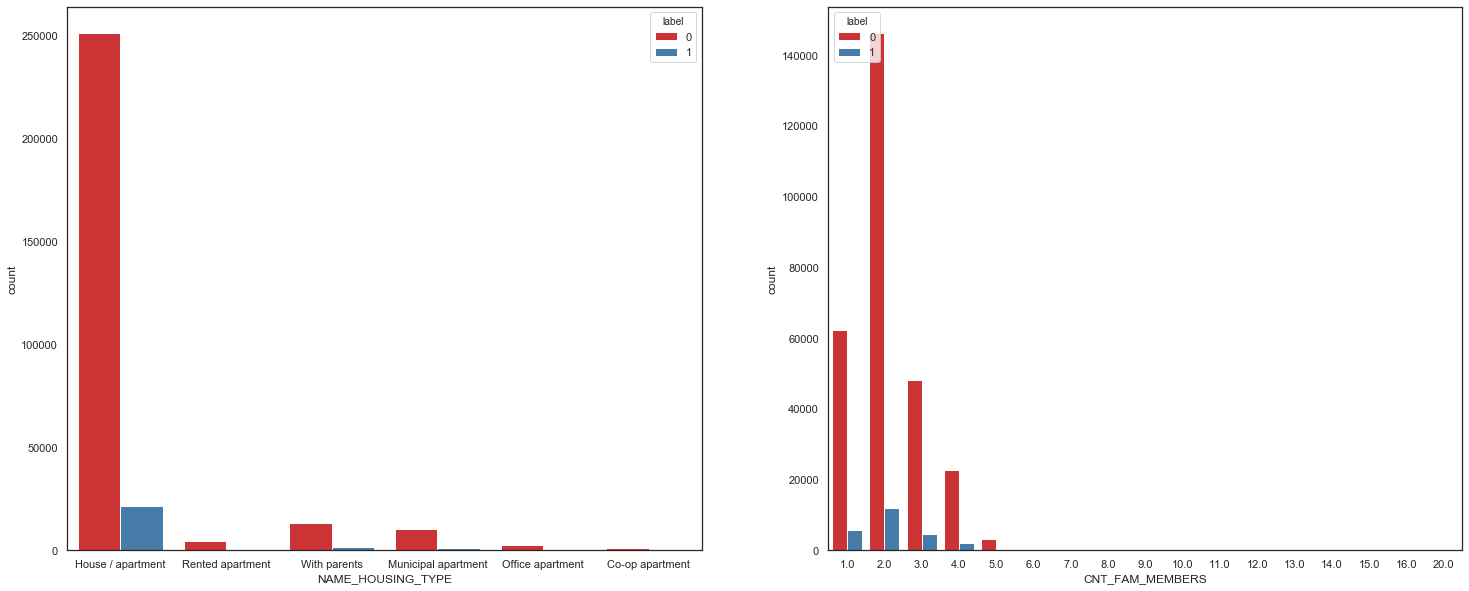

In [20]:
f, axes = plt.subplots(1, 2, figsize=(25, 10))
sns.countplot(x="NAME_HOUSING_TYPE", hue="label", data=loan_history_df_pandas, palette="Set1", ax=axes[0])
sns.countplot(x="CNT_FAM_MEMBERS", hue="label", data=loan_history_df_pandas, palette="Set1", ax=axes[1])

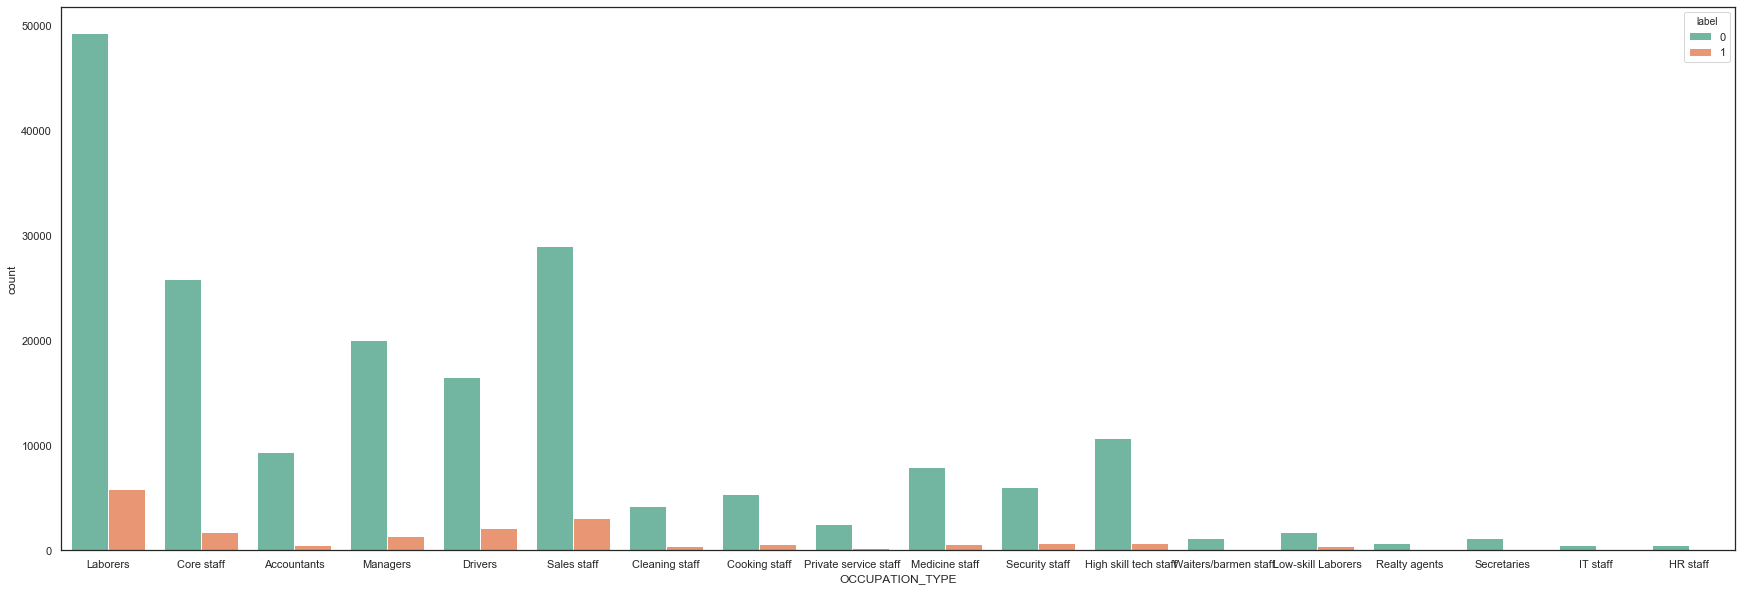

In [21]:
f, axes = plt.subplots(1, 1, figsize=(30, 10))
sns.countplot(x="OCCUPATION_TYPE", hue="label", data=loan_history_df_pandas, palette="Set2", axes = axes)

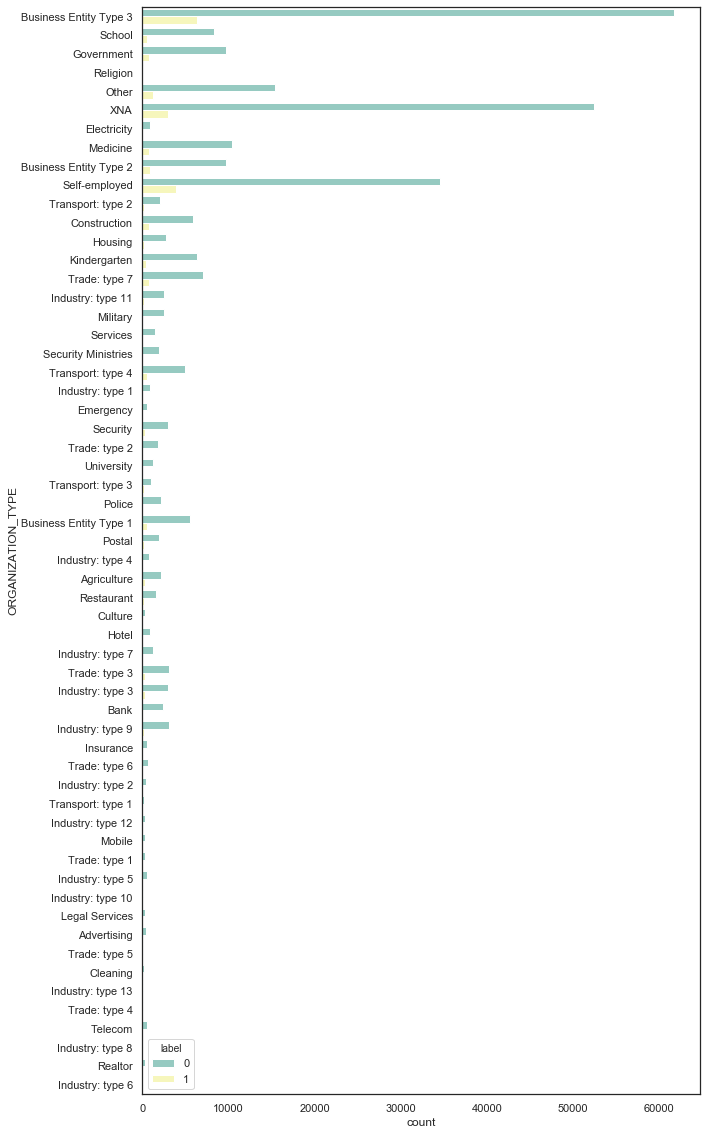

In [22]:
f, axes = plt.subplots(1, 1, figsize=(10, 20))
sns.countplot(y="ORGANIZATION_TYPE", hue="label", data=loan_history_df_pandas, palette="Set3", ax=axes)

In [23]:
correlation_table = loan_history_df_pandas.corr(method='pearson')
correlation_table

,label,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
label,1.000000,0.019187,-0.003982,-0.030369,-0.012817,-0.039645,-0.037227,0.078239,-0.044932,0.041975,...,-0.007952,-0.001358,0.000215,0.003709,0.000930,0.002704,0.000788,-0.012462,-0.002022,0.019930
CNT_CHILDREN,0.019187,1.000000,0.012882,0.002145,0.021374,-0.001827,-0.025573,0.330938,-0.239818,0.183395,...,0.004031,0.000864,0.000988,-0.002450,-0.000410,-0.000366,-0.002436,-0.010808,-0.007836,-0.041550
AMT_INCOME_TOTAL,-0.003982,0.012882,1.000000,0.156870,0.191657,0.159610,0.074796,0.027261,-0.064223,0.027805,...,0.003130,0.002408,0.000242,-0.000589,0.000709,0.002944,0.002387,0.024700,0.004859,0.011690
AMT_CREDIT,-0.030369,0.002145,0.156870,1.000000,0.770138,0.986968,0.099738,-0.055436,-0.066838,0.009621,...,0.034329,0.021082,0.031023,-0.016148,-0.003906,0.004238,-0.001275,0.054451,0.015925,-0.048448
AMT_ANNUITY,-0.012817,0.021374,0.191657,0.770138,1.000000,0.775109,0.118429,0.009445,-0.104332,0.038514,...,-0.009745,0.004573,0.011718,-0.017598,0.003861,0.002185,0.013881,0.039148,0.010124,-0.011320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,0.002704,-0.000366,0.002944,0.004238,0.002185,0.004677,0.001399,0.002255,0.000472,-0.000508,...,0.013281,0.001126,-0.000120,-0.001130,0.230374,1.000000,0.217412,-0.005258,-0.004416,-0.003355
AMT_REQ_CREDIT_BUREAU_WEEK,0.000788,-0.002436,0.002387,-0.001275,0.013881,-0.001007,-0.002149,-0.001336,0.003072,-0.001069,...,-0.004640,-0.001275,-0.001770,0.000081,0.004706,0.217412,1.000000,-0.014096,-0.015115,0.018917
AMT_REQ_CREDIT_BUREAU_MON,-0.012462,-0.010808,0.024700,0.054451,0.039148,0.056422,0.078607,0.001372,-0.034457,-0.011353,...,-0.001565,-0.002729,0.001285,-0.003612,-0.000018,-0.005258,-0.014096,1.000000,-0.007789,-0.004975
AMT_REQ_CREDIT_BUREAU_QRT,-0.002022,-0.007836,0.004859,0.015925,0.010124,0.016432,-0.001279,-0.011799,0.015345,-0.001308,...,-0.005125,-0.001575,-0.001010,-0.002004,-0.002716,-0.004416,-0.015115,-0.007789,1.000000,0.076208


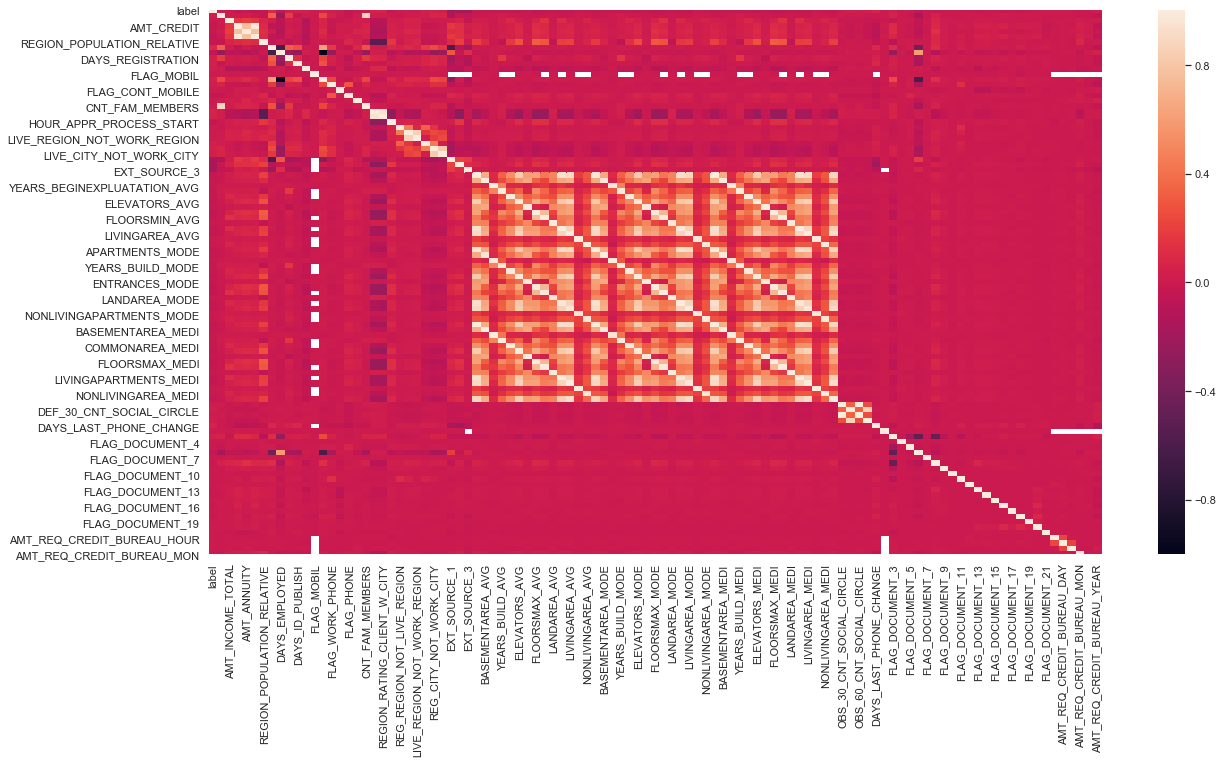

In [24]:
f, axes = plt.subplots(1, 1, figsize=(20, 10))
sns.heatmap(correlation_table, ax=axes)